In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [4]:
import dill

custom_object = {'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=0.25)))}

In [5]:
# useful for getting number of classes
folders = glob('C:/Users/wweis/Deep Learning/CKplus/data/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/CKplus/data/train\\anger', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\contempt', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\disgust', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\fear', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\happy', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\sadness', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\surprise']


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/CKplus/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 1,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=42)

validation_set = test_datagen.flow_from_directory(
        'C:/Users/wweis/Deep Learning/CKplus/data/valid',
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False,
        seed=42)

test_set = test_datagen.flow_from_directory('C:/Users/wweis/Deep Learning/CKplus/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 686 images belonging to 7 classes.
Found 98 images belonging to 7 classes.
Found 197 images belonging to 7 classes.


In [7]:
from keras.models import load_model

# saved_model = load_model("models/CE_CK+.h5")
saved_model = load_model("models/FL_CK+.h5", custom_objects=custom_object)

In [8]:
branch_predictions_train = saved_model.predict(training_set)
branch_predictions_valid = saved_model.predict(validation_set)
branch_predictions_test = saved_model.predict(test_set)

In [9]:
indices_to_remove = [0, 1, 2]
best_train_branch = [arr for index, arr in enumerate(branch_predictions_train) if index not in indices_to_remove]
best_valid_branch = [arr for index, arr in enumerate(branch_predictions_valid) if index not in indices_to_remove]
best_test_branch = [arr for index, arr in enumerate(branch_predictions_test) if index not in indices_to_remove]

best_train_branch = np.array(best_train_branch)
best_valid_branch = np.array(best_valid_branch)
best_test_branch = np.array(best_test_branch)

In [10]:
# Extract probability features from each classifier using the best model
features_train = []
for i in range(len(best_train_branch)):
    probs = best_train_branch[i]
    features_train.append(probs)

features_valid = []
for i in range(len(best_train_branch)):
    probs = best_valid_branch[i]
    features_valid.append(probs)

features_test = []
for i in range(len(best_train_branch)):
    probs = best_test_branch[i]
    features_test.append(probs)
    
features_train = np.array(features_train)
features_valid = np.array(features_valid)
features_test = np.array(features_test)

In [11]:
probs_train = []
for i in range(len(training_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_train[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_train.append(probs_concatenated)
    
probs_valid = []
for i in range(len(validation_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_valid[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_valid.append(probs_concatenated)
    
probs_test = []
for i in range(len(test_set)):
    probs_values = []
    for j in range(len(best_train_branch)):
        prob = features_test[j, i]
        probs_values.append(prob)
    probs_concatenated = np.concatenate(probs_values, axis=0)
    probs_test.append(probs_concatenated)
    
probs_train = np.array(probs_train)
probs_valid = np.array(probs_valid)
probs_test = np.array(probs_test)

In [12]:
from keras.utils import np_utils
# one hot encode outputs
y_train = np_utils.to_categorical(training_set.labels, num_classes=len(folders))
y_valid = np_utils.to_categorical(validation_set.labels, num_classes=len(folders))
y_test = np_utils.to_categorical(test_set.labels, num_classes=len(folders))

In [13]:
# Step 7: Train the multilayer perceptron using the probability features
mlp = Sequential()
mlp.add(Dense(512, activation='relu', input_shape=(14,)))
mlp.add(Flatten())
mlp.add(Dense(512, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(7, activation='softmax'))

In [14]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 4

In [15]:
# Compile and train the MLP
# mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.compile(optimizer='adam', loss=categorical_focal_loss(0.25), metrics=['accuracy'])
hist1 = mlp.fit(probs_train, y_train, validation_data=(probs_valid, y_valid), batch_size=32, epochs=20)

Epoch 1/20
22/22 [==============================] - 1s 18ms/step - loss: 0.1390 - accuracy: 0.9227 - val_loss: 0.0058 - val_accuracy: 0.9898
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 3.9556e-04 - accuracy: 0.9971 - val_loss: 0.0068 - val_accuracy: 0.9898
Epoch 3/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 0.9985 - val_loss: 0.0025 - val_accuracy: 0.9796
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 6.3107e-04 - accuracy: 0.9956 - val_loss: 0.0216 - val_accuracy: 0.9898
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 0.9971 - val_loss: 0.0036 - val_accuracy: 0.9898
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 9.2983e-04 - accuracy: 0.9985 - val_loss: 0.0066 - val_accuracy: 0.9898
Epoch 7/20
22/22 [==============================] - 0s 7ms/step - loss: 6.5522e-04 - accuracy: 0.9985 - val_loss: 0.0070 - val_accuracy: 0.9898
Ep

In [16]:
score_mlp = mlp.evaluate(probs_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 0.9949


In [17]:
from sklearn.metrics import classification_report

predicted = mlp.predict(probs_test)

In [18]:
y_pred_label = np.argmax(predicted, axis=1)

In [19]:
report = classification_report(test_set.labels, y_pred_label)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        41
           5       1.00      0.94      0.97        17
           6       1.00      1.00      1.00        50

    accuracy                           0.99       197
   macro avg       0.99      0.99      0.99       197
weighted avg       1.00      0.99      0.99       197



In [20]:
# score_valid = saved_model.evaluate(test_set)

In [21]:
# pred = saved_model.predict(test_set)

# # Get the number of unique labels
# num_labels = len(np.unique(test_set.classes))

# predicted_class_indices = []

# for branch in range(5):
#     predicted_class_indices.append(np.argmax(pred[branch],axis=1))

# # Define a list of label names
# label_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# # Compute the accuracy for each label
# for branch in range(5):
#     predicted_class = predicted_class_indices[branch]

#     label_accs = {}
#     for label in range(num_labels):
#         idx = np.where(test_set.classes == label)[0]
#         label_acc = np.mean(predicted_class[idx] == test_set.classes[idx])
#         label_accs[label_names[label]] = label_acc

#     # Print the accuracy for each label
#     for label, acc in label_accs.items():
#         print(f"Accuracy for label {label}: {acc:.2f}")
#     print("\n")

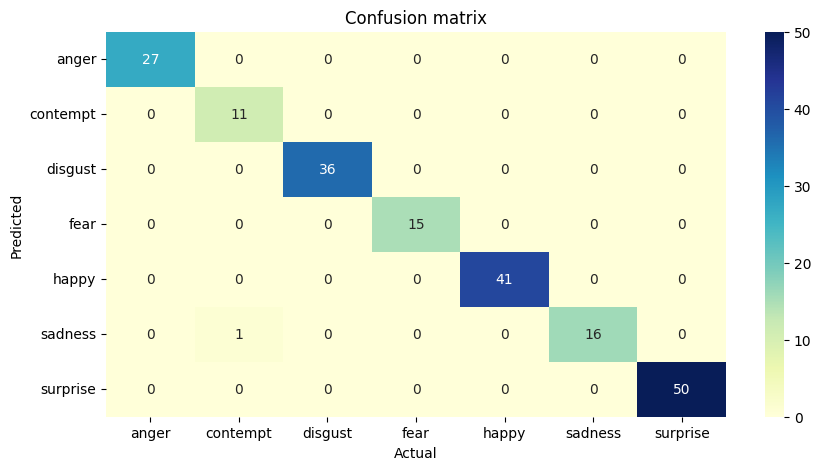

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 5))

# Get the true labels for the test set
# y_true = test_set.classes


# Compute the confusion matrix for the current branch
conf_mat = confusion_matrix(test_set.labels,y_pred_label)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                    columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])

# Create a subplot for the current branch
# plt.subplot(3, 2, branch+1)  # Adjust the subplot layout as needed
plt.title("Confusion matrix")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Adjust the spacing between subplots if necessary
# plt.tight_layout()

# Show the plot
plt.show()


In [23]:
# from sklearn.metrics import classification_report

# for branch in range(5):
#     # Assuming y_true and y_pred are the true and predicted labels
#     report = classification_report(y_true, predicted_class_indices[branch])
#     print(report)

In [24]:
# branch_predictions = [score_valid[6], score_valid[7], score_valid[8], score_valid[9], score_valid[10]]

# # Assuming you have the predicted probabilities from each model stored in a list
# model_predictions = [pred[0], pred[1], pred[2], pred[3], pred[4]]

# branch_left = len(model_predictions)

In [25]:
# import pandas as pd

# for m in range(branch_left-1):
#     print(len(model_predictions))
#     # Calculate the product of probabilities for each class across all models
#     ensemble_pred_probs_product = np.prod(model_predictions, axis=0)
#     ensemble_pred_probs_max = np.max(model_predictions, axis=0)
#     ensemble_pred_probs_mean = np.mean(model_predictions, axis=0)

#     ensemble_pred = [ensemble_pred_probs_product, ensemble_pred_probs_max, ensemble_pred_probs_mean]
    
#     class_data = []

#     for k in range(len(ensemble_pred)):
#         data = []

#         for i in range(len(pred[0])):
#             sample_data = []
#             sample_data.append("Sample " + str(i+1))

#             for j in range(len(folders)):
#                 ensemble_pred_probs = ensemble_pred[k]
#                 sample_data.append(ensemble_pred_probs[i,j])

#             data.append(sample_data)

#         df = pd.DataFrame(data, columns=["Sample", 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
#         df.to_excel("valid_"+str(m)+"_"+str(k)+".xlsx", index=False)

#         # Get the predicted classes by selecting the class with the highest probability
#         ensemble_pred_classes = np.argmax(ensemble_pred_probs, axis=1)

#         # Print the ensemble predictions
#         for i in range(len(ensemble_pred_classes)):
#             class_data.append("Sample" + str(i+1))
#             class_data.append(test_set.labels[i])
#             class_data.append(ensemble_pred_classes[i])
# #             print("Sample", i+1, ": Predicted class:", ensemble_pred_classes[i])

#         # Assuming you have the true labels for the validation set stored in a variable
#         true_labels = test_set.labels

#         # Calculate the accuracy of the ensemble predictions
#         accuracy = np.mean(ensemble_pred_classes == true_labels) * 100
#         class_data.extend(["Accuracy", "", accuracy])

#         print("Ensemble accuracy on the valid set: {:.2f}%".format(accuracy))
        
#         df1 = pd.DataFrame(np.array(class_data).reshape(-1, 3), columns=["Sample", 'Actual', 'Predicted'])
#         df1.to_excel("Predicted_valid_"+str(m)+".xlsx", index=False)
    
#     if(len(model_predictions)>2):
#         lowest_accuracy_branch_idx = np.argmin(branch_predictions)
#         branch_predictions.pop(lowest_accuracy_branch_idx)
#         model_predictions.pop(lowest_accuracy_branch_idx)
    
#     print("-----------------------------------------------------------------------------------------------------")

In [27]:
# Saving the model

# mlp.save('C:/Users/wweis/Deep Learning/CKplus/models/MLP_FL_CK+.h5')